In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
file_name = '/Users/arielle/Downloads/Incidents_Responded_to_by_Fire_Companies.csv'

In [ ]:
# Read in original csv file and perform datetime conversion. This takes time, so intermediate file saved!

df = pd.read_csv(file_name)
df.INCIDENT_DATE_TIME = pd.to_datetime(df.INCIDENT_DATE_TIME)
df.ARRIVAL_DATE_TIME = pd.to_datetime(df.ARRIVAL_DATE_TIME)

df.to_csv('/Users/arielle/Downloads/Incidents_Responded_to_by_Fire_Companies_mod.csv')

In [2]:
# Read in modified file
df = pd.read_csv('/Users/arielle/Downloads/Incidents_Responded_to_by_Fire_Companies_mod.csv')

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#### Question: What proportion of incidents were the most common one? 

# First determine most common incident
inc_label = 'INCIDENT_TYPE_DESC'
modes = df.mode()
common_inc = modes[inc_label][0]
print('The most common incident is: {}'.format(common_inc))

proportion = np.mean(df[inc_label] == common_inc)
print('The proportion of FDNY responses associated with {} incident was: {}'.\
      format(common_inc, np.round(proportion,4)))


The most common incident is: 300 - Rescue, EMS incident, other
The proportion of FDNY responses associated with 300 - Rescue, EMS incident, other incident was: 0.3599


In [4]:
#### Question: What is the ratio of the average number of units...
units_label = 'UNITS_ONSCENE'
n_bldg_fire = df[df.INCIDENT_TYPE_DESC.str.contains('111')][units_label]
n_smk_scare = df[df.INCIDENT_TYPE_DESC.str.contains('651')][units_label]

print(np.nanmean(n_bldg_fire))
print(np.nanmean(n_smk_scare))
print('Ratio: ' + str(np.true_divide(np.nanmean(n_bldg_fire), np.nanmean(n_smk_scare))))
# print(vals)

11.2201025057
4.00552400363
Ratio: 2.80115722575


In [5]:
#### Question: False call rate for staten island vs. manhattan

df_false_calls = df[df.INCIDENT_TYPE_DESC.str.contains('710')]
location_label = 'BOROUGH_DESC'
staten = '3 - Staten Island'
man = '1 - Manhattan'
locations = [staten, man]

# calculate number of false calls & number of total calls to compute rate for each location
false_calls = np.zeros((len(locations)))
total_calls = np.zeros_like(false_calls)
for ilocation, location in enumerate(locations):
    false_calls[ilocation] = np.sum(df_false_calls[location_label] == location)
    total_calls[ilocation] = np.sum(df[location_label] == location)
    
# false call rate
false_call_rate = np.true_divide(false_calls, total_calls)

# staten island vs. manhattan
print('False call rate for Staten Island vs. Manhattan:  ' + \
      str(np.round(false_call_rate[0]/false_call_rate[1],4)))

False call rate for Staten Island vs. Manhattan:  1.603


In [6]:
#### Question: 75th percentile of times between arrival vs. report of BUILDING FIRE incidents
df_fire = df[df.INCIDENT_TYPE_DESC.str.contains('111')]
df_fire_td_all = (pd.to_datetime(df_fire.ARRIVAL_DATE_TIME) - pd.to_datetime(df_fire.INCIDENT_DATE_TIME))\
    .astype('timedelta64[s]')
print('# of building fire incidents: ' + str(len(df_fire_td_all)))

# of building fire incidents: 14202


/Applications/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


75th percentile: 4.1667
Answer is 4 1/6, but fraction was not accepted as answer -- only float


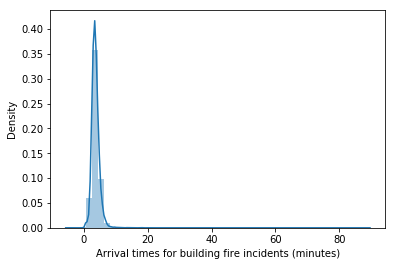

In [7]:
# convert to minutes
df_fire_td = df_fire_td_all[np.isnan(df_fire_td_all)==0] / 60
sns.distplot(df_fire_td)
plt.xlabel('Arrival times for building fire incidents (minutes)')
print('75th percentile: ' + str(np.round(np.percentile(df_fire_td, 75),4)))
print('Answer is 4 1/6, but fraction was not accepted as answer -- only float')

In [8]:
#### Question: rate of cooking incidents at the hour of maximum rate of cooking incidents

df_cook_t = pd.to_datetime(df[df.INCIDENT_TYPE_DESC.str.contains('113')].INCIDENT_DATE_TIME)

# hours of cooking incidents
hours_cook = df_cook_t.dt.hour 

# hours of all incidents
hours_all = pd.to_datetime(df.INCIDENT_DATE_TIME).dt.hour

# array of possible hours
poss_hours = np.unique(hours_all)

Max. rate of cooking incidents: [ 0.0511]


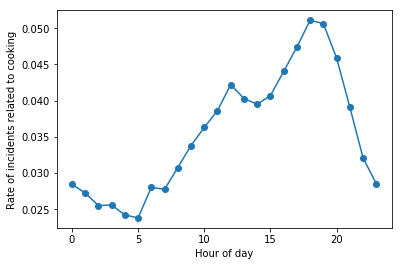

In [9]:
Nhours = len(poss_hours)

# number of incidents at each hour
cook_count = np.zeros((Nhours))
all_count = np.zeros_like(cook_count)
for hour in poss_hours:
    cook_count[hour] = np.sum(hours_cook==hour)
    all_count[hour] = np.sum(hours_all==hour)

# rate of cooking incidents at each hour
cook_rate = np.true_divide(cook_count, all_count)

plt.figure
plt.plot(poss_hours, cook_rate,'-o')
plt.xlabel('Hour of day')
plt.ylabel('Rate of incidents related to cooking')
print('Max. rate of cooking incidents: ' + str(np.round(cook_rate[cook_rate==max(cook_rate)],4)))

In [10]:
#### Question: is population related to # of building fire incidents in each zip code?

# Calculate number of incidents per zip 
df_fire.ZIP_CODE = df_fire.ZIP_CODE.astype('int')
df_info = df_fire.groupby('ZIP_CODE').count()
df_info.index = df_info.index.astype('int')
np.sort(df_info.index)
df_y = pd.DataFrame({'Zip Code': df_info.index.astype('int'), \
                     'NumFireInc': df_info.INCIDENT_DATE_TIME}, index=None)


/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
# Read in population information
zip_pop_df = pd.read_html('https://www.newyork-demographics.com/zip_codes_by_population')[0]
zip_pop_df = zip_pop_df[:-1] # last row is junk

# need to clean data - deal with TIE entries
# noramlize the separators
zip_pop_df['Zip Code'] = zip_pop_df['Zip Code'].astype('str')
zip_pop_df['Zip Code'] = zip_pop_df['Zip Code'].apply(lambda x: x.replace(",", "").replace("and ", ""))

# expand "and" duplicates
data_zip = zip_pop_df['Zip Code'].str.split(' ', expand=True).stack().reset_index(level = 1,drop = True)

# join with full dataframe
zip_pop_df = zip_pop_df.drop(['Zip Code'], axis=1).join(data_zip.to_frame(name = 'Zip Code'))

zip_pop_df = zip_pop_df.dropna()

In [12]:
# merge population information & fire incidents
zip_pop_df['Zip Code'] = zip_pop_df['Zip Code'].astype('int64')
df_y['Zip Code'] = df_y['Zip Code'].astype('int64')

df_merge = zip_pop_df.join(df_y, on='Zip Code', how='inner', lsuffix='_i', rsuffix='_l')
df_merge.head()
df_merge['Population'] = df_merge['Population'].astype('float64')

Population accounts for 63.0 % of variance in # of building fires
R squared = 0.6259016202


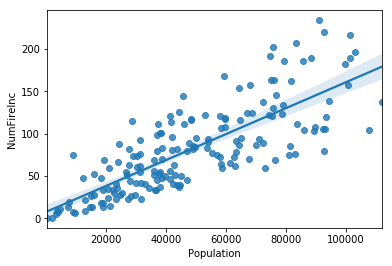

In [13]:
# Population vs. Number of building fire incidents
plt.figure
sns.regplot(data=df_merge, x='Population', y='NumFireInc')

from sklearn.linear_model import LinearRegression

x = np.array(df_merge.Population).reshape(-1, 1)
y = np.array(df_merge.NumFireInc).reshape(-1, 1)
res = LinearRegression().fit(x, y)
print('Population accounts for ' + str(np.round(100*res.score(x, y))) + ' % of variance in # of building fires')
print('R squared = ' + str(res.score(x, y)))

In [14]:
#### Question: chi-squared statistic re: CO detector presence and duration of incident

# gather data where information about CO detector is present
df_cocomplete = df.dropna(subset = ['CO_DETECTOR_PRESENT_DESC'])

In [15]:
# calculations for 2 x 2 contingency table 
# calculate time in minutes for events were CO detector was present and absent
min_yes = df_cocomplete[df_cocomplete.CO_DETECTOR_PRESENT_DESC == 'Yes']['TOTAL_INCIDENT_DURATION'] / 60
min_no = df_cocomplete[df_cocomplete.CO_DETECTOR_PRESENT_DESC == 'No']['TOTAL_INCIDENT_DURATION'] / 60

# categories long events as being > 1 hour, short events are <=1 hour
long_yes = np.sum(min_yes > 60)
long_no = np.sum(min_no > 60)
short_yes = np.sum(min_yes <= 60)
short_no = np.sum(min_no <= 60)

# set up 2 x 2 contingency table 
cont_table = np.array([[short_yes, short_no], [long_yes, long_no]])
print(cont_table)

[[25802  5332]
 [  927   941]]


In [16]:
# calculate chi squared statistic
from scipy.stats import chi2_contingency

res = chi2_contingency(cont_table)
print('chisquared stat:  ' + str(res[0]))
print('p-value:  ' + str(res[1]))

chisquared stat:  1263.29116805
p-value:  1.07313304359e-276
